## Predicting

**Importing librairies**


In [1]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
import geopandas as gpd


**Denne nettsiden snakker litt om hvordan jobbe med ubalanserte datasett**

https://medium.com/digital-catapult/dealing-with-imbalanced-data-8b21e6deb6cd

**Importing data**

In [2]:
Filename = "..\data\_tarefelt1.csv"
data = pd.read_csv(Filename)
data_x = data.drop(columns = "label")
data_x = data.drop(columns = "geometry")
data_y = data.label

**Splitting Data**

In [3]:
X_train, X_test ,y_train, y_test = train_test_split( data_x, data_y, test_size=0.30, random_state=42)
X_test, X_val ,y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

**Definerer en batch generator**

In [4]:
def batch(iterable_X, iterable_y, n=1):
    '''
    n: batchsize
    iterable_X: X frame to be iterated over
    iterable_y: y frame to be iterated over
    '''
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]


**Training the model**  


In [5]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(max_iter=1000, tol=1e-3, class_weight= dict(zip(np.unique(y_train), class_weights)))


classes = np.unique(y_train)
accuracy =[]
ROUNDS = 2
count = 0 
batch_size = 10000
for _ in range(ROUNDS):
    X_train, y_train = shuffle(X_train, y_train)
    print(_)
    batcherator = batch(X_train, y_train, batch_size)
    for index, (X, target) in enumerate(batcherator):

        from sklearn.utils.class_weight import compute_class_weight
        print(count)
        count+= 1
        #Using a standardscaler
        scaler = StandardScaler()
        scaler.fit(X) 
        X = scaler.transform(X)
        test = scaler.transform(X_val) 
        clf.partial_fit(X, target, classes)
        y_predicted = clf.predict(test)
        accuracy.append(accuracy_score(y_val, y_predicted))

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
1
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139


**Evaluating Model**


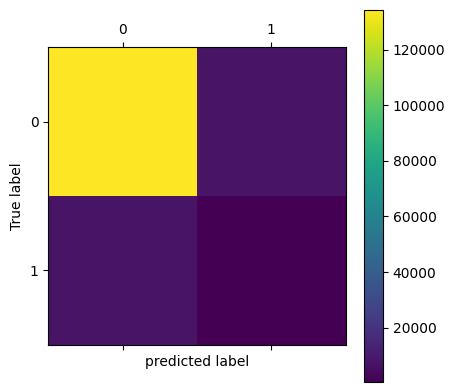

In [6]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)
# Plot matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

**Checking over the test set**

In [7]:
y_predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"The accuracy of the model was {np.round(accuracy,2)}")

The accuracy of the model was 0.95


In [8]:
unique, counts = np.unique(y_predicted, return_counts=True)


In [9]:
print(unique)
print(counts)

[0. 1.]
[149828    172]


In [10]:
y_test.value_counts()


0.0    141984
1.0      8016
Name: label, dtype: int64

**Plotting the predicted seaweed and comparing with naturdirektoratet**

In [11]:
X = X_test.copy()
X["label"] = y_test
X["y_predicted"] = y_predicted
X = gpd.GeoDataFrame(X, geometry=gpd.points_from_xy(X.lon, X.lat))

df_no_seaweed = X[X["y_predicted"] == False].copy()
df_seaweed = X[X["y_predicted"] == True].copy()
df_true_seaweed = X[X["label"] == True].copy()

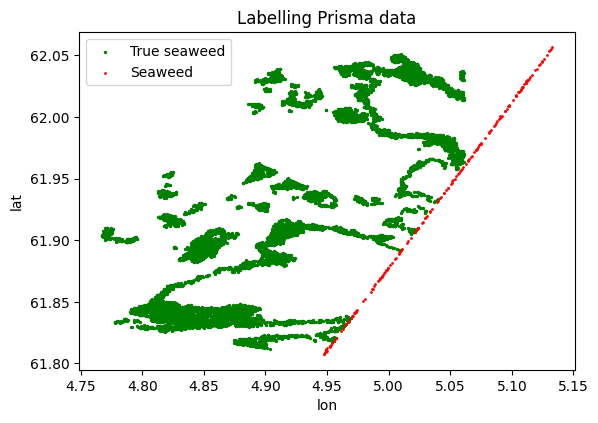

In [12]:
fig, ax = plt.subplots()
#df_no_seaweed.plot(ax = ax, color = "blue", label = "no seaweed")
df_true_seaweed.plot(ax = ax, color = "green", label = "True seaweed", markersize = 2)
df_seaweed.plot(ax = ax, color = "red", label = "Seaweed", markersize = 1)

ax.set_title("Labelling Prisma data")
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.legend()